# Training an Autoencoder for jet images with  **Conv 2D**  

---
In this notebook, we train an Autoencoder on a dataset of QCD jet images.
Both the encoder and decoder networks are based on Conv2D architectures. 
This autoencoder can be used
- as a clustering algorithm in the latent space
- as a compression algorithm
- as an anomaly detection algorithm

Some of these functionalities are exploited below.

The notebook starts prpearing the QCD dataset and a set of
"anomalous jets" (boosted W-, Z-, and top-jets).
The AE is trained on a training+validation dataset. Then, 
it is used on the test dataset for some of the applications listed above. Due to
the low statistics available, the validation dataset is recycled
as a test dataset. 

For details on the dataset, see https://github.com/pierinim/tutorials/blob/master/HiggsSchool/Lecture1/Notebook1_ExploreDataset.ipynb

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [3]:
# not needed if running locally
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset/

fatal: destination path 'tutorials' already exists and is not an empty directory.


In [5]:
import glob
target = np.array([])
jetImage = np.array([])
#----------
# if you are running locally, you should do
# datafiles = glob.glob("../Data/JetDataset/*h5") 
#----------
# on Colab
#----------
datafiles = glob.glob("tutorials/Data/JetDataset/*h5") 
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN, "r")
    myjetImage = np.array(f.get("jetImage"), np.float32)
    mytarget = np.array(f.get('jets')[0:,-6:-1], np.float32)
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, jetImage.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_80000_90000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_70000_80000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_40000_50000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
(80000, 5) (80000, 100, 100)


In keras, images are representable as $n \times m \times k$ tensors, where $n \times m$ are the pixel dimenions and $k$ is the number of channels (e.g., 1 in a black\&while image, 3 for an RGB image). In our case, k=1. To comply to this, we add the channel index by reshaping the image dataset

In [6]:
jetImage = jetImage.reshape((jetImage.shape[0], jetImage.shape[1], jetImage.shape[2], 1))
print(jetImage.shape)

(80000, 100, 100, 1)


We now separate the dataset in 4:
- a training dataset, consisting of quarks and gluons
- three 'anomalous jets' samples: W, Z, and top

In [7]:
jetImage_standard = jetImage[np.argmax(target,axis=1)<2]
jetImage_W = jetImage[np.argmax(target,axis=1)==2]
jetImage_Z = jetImage[np.argmax(target,axis=1)==3]
jetImage_t = jetImage[np.argmax(target,axis=1)==4]
print(jetImage_standard.shape, jetImage_W.shape, jetImage_Z.shape, jetImage_t.shape)

(31755, 100, 100, 1) (16100, 100, 100, 1) (16070, 100, 100, 1) (16075, 100, 100, 1)


Notice that this is an unsupervised algorithm, so we don't need the target array anymore.
Nevertheless, we keep a part of it around, since it might be useful to test the response 
of the algorithm to quarks and gluons separetly

In [8]:
label_standard = target[np.argmax(target,axis=1)<2]
del target
del jetImage

We now shuffle the standard-jet data and its labels, splitting them into a training, a validation+test dataset with 2:1:1 ratio. 

Then we separate the validation+test in two halves (training and validation)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, label_train, label_val = t= train_test_split(jetImage_standard, label_standard, test_size=0.5)
print(X_train.shape, X_val.shape, label_train.shape, label_val.shape)
len_val = X_val.shape[0]
X_test = X_val[int(len_val/2.):,:,:,:]
label_test = label_val[int(len_val/2.):,:]
X_val = X_val[:int(len_val/2.),:,:,:]
label_test = label_val[:int(len_val/2.),:]
print(X_train.shape, X_val.shape, X_test.shape, label_train.shape, label_val.shape, label_test.shape)

(15877, 100, 100, 1) (15878, 100, 100, 1) (15877, 5) (15878, 5)
(15877, 100, 100, 1) (7939, 100, 100, 1) (7939, 100, 100, 1) (15877, 5) (15878, 5) (7939, 5)


In [11]:
# some cleanup to save memory
del jetImage_standard

# Building the ConvAE model

In [12]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Flatten, Activation, Deconv2D
from keras.layers import MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.


In [13]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
image_shape = (img_rows, img_cols, 1)

In [14]:
#---------
# Enncoder
#---------
inputImage = Input(shape=(image_shape))
#
x = Conv2D(10, kernel_size=(5, 5), data_format="channels_last", strides=(1, 1), padding="same")(inputImage)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (5, 5))(x)
#
x = Conv2D(15, kernel_size=(4, 4), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (5, 5))(x)
#
x = Conv2D(20, kernel_size=(4, 4), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (4, 4))(x)
#
x = Flatten()(x)
enc = Dense(5, activation='relu')(x)

#---------
# Decoder
#---------

x = Dense(20, activation='relu')(enc)
x = Reshape((1, 1, 20))(x)
#
x = UpSampling2D((4, 4))(x)
x = BatchNormalization()(x)
x = Deconv2D(15, kernel_size=(4,4), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = Activation('relu')(x)
#
x = UpSampling2D((5, 5))(x)
x = BatchNormalization()(x)
x = Deconv2D(10, kernel_size=(4,4), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = Activation('relu')(x)
#
x = UpSampling2D((5, 5))(x)
x = BatchNormalization()(x)
x = Deconv2D(1, kernel_size=(4,4), data_format="channels_last", strides=(1, 1), padding="same")(x)
dec = Activation('relu')(x)
#output = Deconv2D(5, kernel_size=(5,5), data_format="channels_last", strides=(1, 1), padding="same")(x)
####
AE_enc = Model(inputs=inputImage, outputs=enc)
AE = Model(inputs=inputImage, outputs=dec)

W0715 09:24:54.073288 4606019008 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 09:24:54.090296 4606019008 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 09:24:54.093460 4606019008 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 09:24:54.133781 4606019008 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0715 09:24:54.134510 4606019008 deprecation_wrapper

In [15]:
AE.compile(loss='mse', optimizer='adam')
AE.summary()

W0715 09:25:00.756525 4606019008 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 10)      260       
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 10)      40        
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 10)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 15)        2415      
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 15)        60        
__________

In [17]:
batch_size = 128
n_epochs = 100

In [18]:
# train 
history = AE.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, X_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 15877 samples, validate on 7939 samples
Epoch 1/1
 - 122s - loss: 32.0394 - val_loss: 33.4200


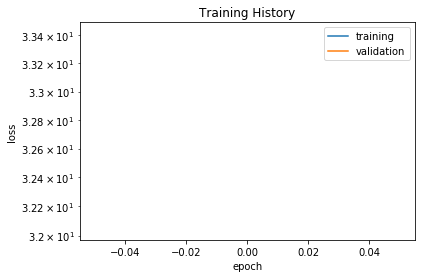

In [19]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Anomaly Detection

In order to detect anomalous jets, we build the distribution of the reconstruction loss (the MSE term) and define as anomaly all the jets falling in the tail, at some fixed p-value. 
To evaluate the strength of the test, we can consider a set of anomalies and evaluate the ROC curves

### Loss Distributions

In [20]:
labels = ['W', 'Z', 'top']

In [21]:
anomaly = [jetImage_W, jetImage_Z, jetImage_t]
predictedQCD = AE.predict(X_test)
predicted_anomaly = []
for i in range(len(labels)):
    predicted_anomaly.append(AE.predict(anomaly[i]))

In [22]:
def mse(image_in, image_out):
    mse = (image_out-image_in)*(image_out-image_in)
    # sum over channel
    mse = np.sum(mse,axis=-1)
    # sum over y
    mse = np.sum(mse, axis=-1)
    # sum over x
    mse = np.sum(mse, axis=-1)
    return mse    

In [23]:
lossQCD = mse(X_test, predictedQCD)
loss_anomaly = []
for i in range(len(labels)):
    loss_anomaly.append(mse(anomaly[i], predicted_anomaly[i]))

In [24]:
lossQCD_1 = lossQCD

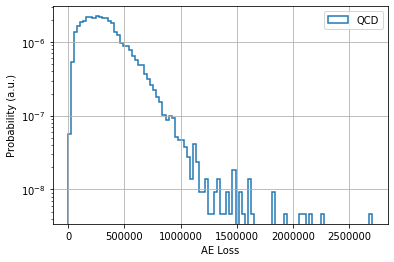

In [25]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD_1, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

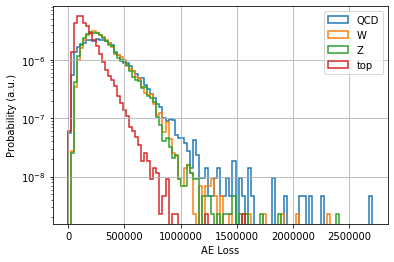

In [26]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
for i in range(len(labels)):
    plt.hist(loss_anomaly[i], bins=100, label=labels[i], density=True, range=(0, maxScore),
            histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

### Building the ROC Curves

(16100,) (7939,)
(24039,) (24039,)
(16070,) (7939,)
(24009,) (24009,)
(16075,) (7939,)
(24014,) (24014,)


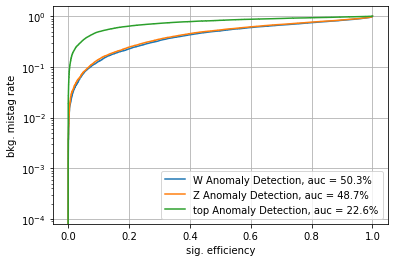

In [27]:
from sklearn.metrics import roc_curve, auc
plt.figure()
targetQCD = np.zeros(lossQCD.shape[0])
for i, label in enumerate(labels):
        print(loss_anomaly[i].shape, targetQCD.shape)
        trueVal = np.concatenate((np.ones(loss_anomaly[i].shape[0]),targetQCD))
        predVal = np.concatenate((loss_anomaly[i],lossQCD))
        print(trueVal.shape, predVal.shape)
        fpr, tpr, threshold = roc_curve(trueVal,predVal)
        auc1= auc(fpr, tpr)
        plt.plot(tpr,fpr,label='%s Anomaly Detection, auc = %.1f%%'%(label,auc1*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

# Clustering

When encoding images, the AE should make alike images fall in closeby points of the bottle-neck latent space.
The distribution in the latent space can then be used to identify in an unsupervised way groups of similar images